# Pipeline Preprocessing Citra untuk OCR Running Text

## Tahapan Pemrosesan:

### 1. **Region of Interest (ROI) Extraction**
   - Crop area running text (bagian bawah video)
   - Hilangkan logo & timestamp yang mengganggu

### 2. **Image Enhancement**
   - **Upscaling**: Perbesar gambar 3x untuk meningkatkan detail
   - **Grayscale Conversion**: Konversi ke skala abu-abu
   - **Gaussian Blur**: Reduksi noise awal

### 3. **Binarization (Thresholding)**
   - **Adaptive Thresholding**: Pisahkan teks dari background
   - Mode: `THRESH_BINARY_INV` (background putih, teks hitam)

### 4. **Noise Removal**
   - **Morphological Opening**: Hilangkan noise kecil (salt noise)
   - **Connected Components**: Filter komponen berdasarkan ukuran minimal

### 5. **Text Enhancement** 
   - **Morphological Closing**: Hubungkan karakter yang terputus
   - **Dilation**: Perjelas ketebalan teks

### 6. **OCR Configuration**
   - **PSM 7 / PSM 13**: Mode single line untuk running text
   - **OEM 1**: LSTM engine (akurasi tinggi)
   - **Post-processing**: Cleaning karakter noise

---

## Parameter Kunci yang Perlu Disesuaikan:

| Parameter | Fungsi | Nilai Optimal |
|-----------|--------|---------------|
| `fx, fy` | Scaling factor | 3x - 4x |
| `GaussianBlur` | Kernel size | (5,5) atau (7,7) |
| `adaptiveThreshold` | Block size | 15-25 (ganjil) |
| `MORPH_OPEN` | Kernel & iterations | (2,2), iter=1 |
| `min_size` | Filter noise | 30-100 pixel |
| `PSM` | Tesseract mode | 7 atau 13 |

In [37]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import os
import numpy as np

video_path = os.path.join('data', 'input', '10 menit 1 November.mp4')

Ukuran ROI Setelah Crop: Tinggi 48px, Lebar 414px


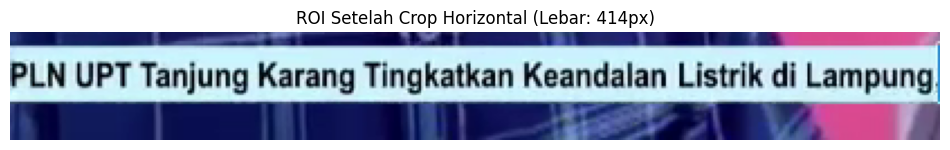

In [39]:
# Ambil frame spesifik
frame_number = 9923
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()

# 1. Crop vertikal: 10% bagian bawah
height, width = frame.shape[:2]
roi = frame[int(0.9*height):height, :, :].copy()

# 2. Crop horizontal: HILANGKAN LOGO & TIMESTAMP
# Sesuaikan nilai ini berdasarkan gambar Anda:
left_crop = 179  # Potong 120px dari kiri (untuk logo)
right_crop = 127  # Potong 100px dari kanan (untuk timestamp)
refined_roi = roi[:, left_crop:width-right_crop, :].copy()

# tampilkan metadata ROI
print(f'Ukuran ROI Setelah Crop: Tinggi {refined_roi.shape[0]}px, Lebar {refined_roi.shape[1]}px')


# Tampilkan ROI hasil crop
plt.figure(figsize=(12, 3))
plt.imshow(cv2.cvtColor(refined_roi, cv2.COLOR_BGR2RGB))
plt.title(f'ROI Setelah Crop Horizontal (Lebar: {refined_roi.shape[1]}px)')
plt.axis('off')
plt.show()

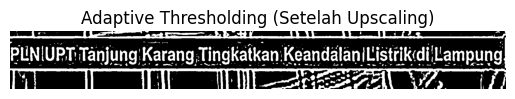

In [47]:
# Code Cell 3 (Diperbaiki)
# 1. Rescale ke 300% sebelum preprocessing
resized_roi = cv2.resize(refined_roi, (0,0), fx=4, fy=4, interpolation=cv2.INTER_CUBIC)

# 2. Gunakan adaptive thresholding (lebih baik untuk kontras rendah)
gray = cv2.cvtColor(resized_roi, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)  # Lebih kuat dari median blur
thresh = cv2.adaptiveThreshold(
    blurred, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 
    19, 
    2
)

# Tampilkan hasil
plt.imshow(thresh, cmap='gray')
plt.title('Adaptive Thresholding (Setelah Upscaling)')
plt.axis('off')
plt.show()

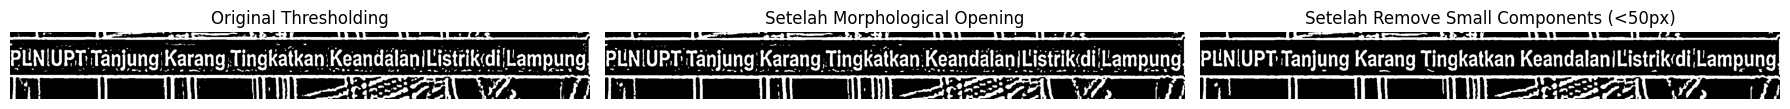

Jumlah komponen terdeteksi: 270
Komponen setelah filtering: 1


In [48]:
# Menghilangkan noise kecil-kecil
# 1. Morphological Opening (erosi kemudian dilasi) - menghilangkan noise putih kecil
kernel_small = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_small, iterations=1)

# 2. Median Filter - alternatif untuk menghilangkan salt-and-pepper noise
# denoised = cv2.medianBlur(thresh, 3)

# 3. Connected Components - hapus komponen yang terlalu kecil (noise)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opening, connectivity=8)
min_size = 50  # Hapus komponen lebih kecil dari 50 pixel

# Buat mask untuk komponen yang cukup besar
cleaned = np.zeros_like(opening)
for i in range(1, num_labels):  # Skip background (label 0)
    if stats[i, cv2.CC_STAT_AREA] >= min_size:
        cleaned[labels == i] = 255

# Tampilkan perbandingan
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].imshow(thresh, cmap='gray')
axes[0].set_title('Original Thresholding')
axes[0].axis('off')

axes[1].imshow(opening, cmap='gray')
axes[1].set_title('Setelah Morphological Opening')
axes[1].axis('off')

axes[2].imshow(cleaned, cmap='gray')
axes[2].set_title(f'Setelah Remove Small Components (<{min_size}px)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Jumlah komponen terdeteksi: {num_labels-1}")
print(f"Komponen setelah filtering: {np.sum(np.unique(cleaned) == 255)}")

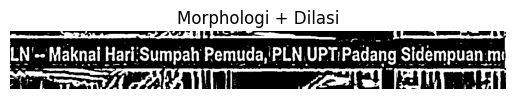

In [5]:
# Code Cell 5 (Diperbaiki)
# 1. Gunakan kernel lebih besar untuk morphologi
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

# 2. Tambahkan dilasi untuk memperjelas teks
dilated = cv2.dilate(closed, kernel, iterations=1)

# Tampilkan hasil
plt.imshow(dilated, cmap='gray')
plt.title('Morphologi + Dilasi')
plt.axis('off')
plt.show()

Teks yang Terdeteksi:
PENJUPTTanjung Karang Tingkatkan Keandalan Uistik di Lampung

Panjang teks: 60 karakter


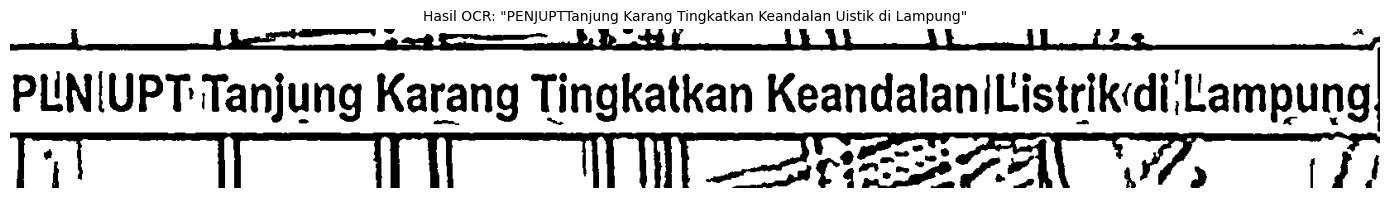


💡 Tips Konfigurasi:
- PSM 7: Single line (TERBAIK untuk running text)
- PSM 13: Raw line (jika PSM 7 tidak optimal)
- Gunakan whitelist jika tahu karakter yang valid
- Gunakan blacklist untuk ignore simbol noise tertentu


In [49]:
# OCR dengan Tesseract - Optimized untuk Running Text
# Konversi ke format yang sesuai untuk OCR (hitam-putih dengan teks hitam)
ocr_ready = cv2.bitwise_not(cleaned)  # Inversi agar teks berwarna hitam

# Konfigurasi Tesseract untuk Running Text (Single Line):
# --oem 1          : Gunakan LSTM OCR Engine Mode (akurasi terbaik)
# --psm 7          : Treat image as single TEXT LINE (cocok untuk running text)
# -l ind           : Bahasa Indonesia
# -c tessedit_char_whitelist : Batasi karakter yang dikenali (opsional)
# tessedit_char_blacklist    : Abaikan karakter tertentu (simbol noise)

# Opsi PSM (Page Segmentation Mode) untuk running text:
# PSM 7  = Single text line (TERBAIK untuk running text)
# PSM 13 = Raw line (tanpa analisis layout)
# PSM 6  = Uniform block of text (default)

custom_config = r'--oem 1 --psm 13 -l ind'

# Alternatif dengan whitelist (hanya huruf, angka, spasi, tanda baca umum):
# custom_config = r'--oem 1 --psm 7 -l ind -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789 .,:;!?/-'

# Untuk ignore simbol noise tertentu:
# custom_config = r'--oem 1 --psm 7 -l ind -c tessedit_char_blacklist=|@#$%^&*()_+=[]{}~`'

text = pytesseract.image_to_string(ocr_ready, config=custom_config)

# Post-processing: Bersihkan hasil OCR
text_cleaned = text.strip()
# Hapus multiple spaces
text_cleaned = ' '.join(text_cleaned.split())
# Hapus karakter noise yang mungkin muncul
import re
text_cleaned = re.sub(r'[|~`]', '', text_cleaned)

# Tampilkan hasil
print("Teks yang Terdeteksi:")
print("="*50)
print(text_cleaned)
print("="*50)
print(f"\nPanjang teks: {len(text_cleaned)} karakter")

# Visualisasi hasil akhir dengan teks
plt.figure(figsize=(14, 3))
plt.imshow(ocr_ready, cmap='gray')
plt.title(f'Hasil OCR: "{text_cleaned}"', fontsize=10)
plt.axis('off')
plt.tight_layout()
plt.show()

# Tips tambahan untuk meningkatkan akurasi:
print("\n💡 Tips Konfigurasi:")
print("- PSM 7: Single line (TERBAIK untuk running text)")
print("- PSM 13: Raw line (jika PSM 7 tidak optimal)")
print("- Gunakan whitelist jika tahu karakter yang valid")
print("- Gunakan blacklist untuk ignore simbol noise tertentu")

---
## 🎯 Teknik Optimasi Tambahan untuk Running Text

Jika hasil OCR masih kurang optimal, coba teknik berikut:

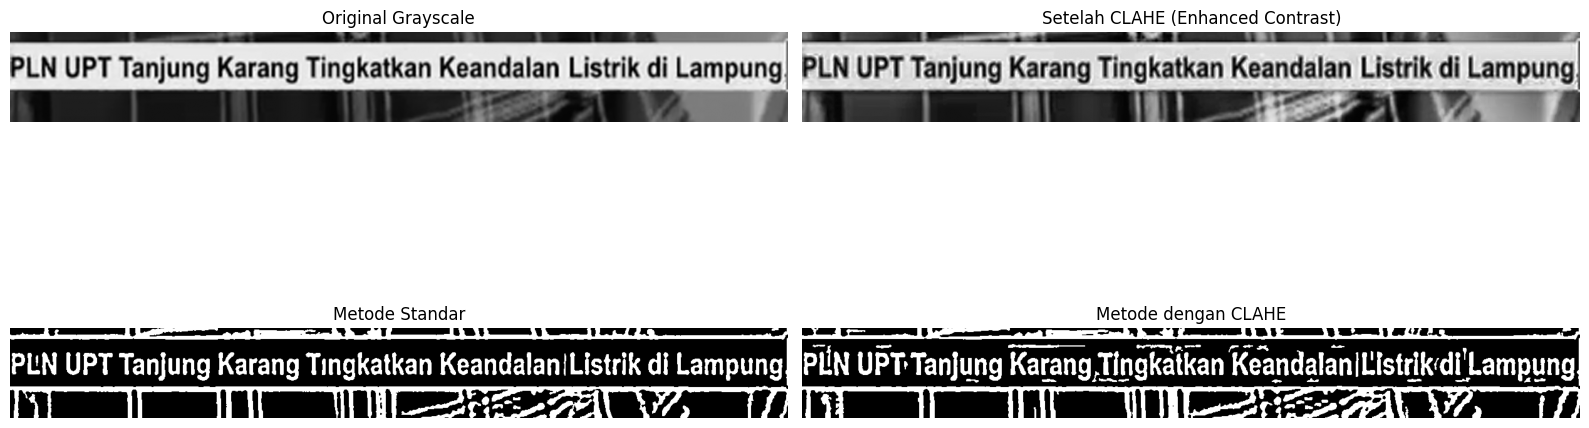

🔍 Hasil OCR - Metode CLAHE:
PAN UPT Tanjung Karang Tingkikan Keandalan Listik Lampung


In [43]:
# ========================================
# TEKNIK 1: Contrast Limited Adaptive Histogram Equalization (CLAHE)
# ========================================
# Meningkatkan kontras lokal untuk teks yang redup

gray_enhanced = cv2.cvtColor(resized_roi, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(gray_enhanced)

# Thresholding setelah CLAHE
blurred_clahe = cv2.GaussianBlur(enhanced, (5,5), 0)
thresh_clahe = cv2.adaptiveThreshold(
    blurred_clahe, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 
    19, 
    2
)

# Noise removal
opening_clahe = cv2.morphologyEx(thresh_clahe, cv2.MORPH_OPEN, kernel_small, iterations=1)

# Connected components filtering
num_labels_clahe, labels_clahe, stats_clahe, _ = cv2.connectedComponentsWithStats(opening_clahe, connectivity=8)
cleaned_clahe = np.zeros_like(opening_clahe)
for i in range(1, num_labels_clahe):
    if stats_clahe[i, cv2.CC_STAT_AREA] >= min_size:
        cleaned_clahe[labels_clahe == i] = 255

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

axes[0, 0].imshow(gray_enhanced, cmap='gray')
axes[0, 0].set_title('Original Grayscale')
axes[0, 0].axis('off')

axes[0, 1].imshow(enhanced, cmap='gray')
axes[0, 1].set_title('Setelah CLAHE (Enhanced Contrast)')
axes[0, 1].axis('off')

axes[1, 0].imshow(cleaned, cmap='gray')
axes[1, 0].set_title('Metode Standar')
axes[1, 0].axis('off')

axes[1, 1].imshow(cleaned_clahe, cmap='gray')
axes[1, 1].set_title('Metode dengan CLAHE')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# OCR comparison
ocr_ready_clahe = cv2.bitwise_not(cleaned_clahe)
text_clahe = pytesseract.image_to_string(ocr_ready_clahe, config=custom_config)
text_clahe_cleaned = ' '.join(text_clahe.strip().split())

print("🔍 Hasil OCR - Metode CLAHE:")
print("="*50)
print(text_clahe_cleaned)
print("="*50)

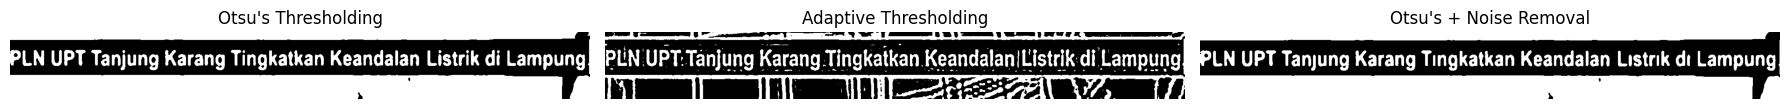

🔍 Hasil OCR - Metode Otsu:
PLN UPT Tanjung Karang Tingkatkan Keandalan Lisinik di Lampung


In [44]:
# ========================================
# TEKNIK 2: Otsu's Binarization (Automatic Thresholding)
# ========================================
# Menentukan threshold optimal secara otomatis

gray_otsu = cv2.cvtColor(resized_roi, cv2.COLOR_BGR2GRAY)
blurred_otsu = cv2.GaussianBlur(gray_otsu, (5,5), 0)

# Otsu's thresholding
_, thresh_otsu = cv2.threshold(blurred_otsu, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal
opening_otsu = cv2.morphologyEx(thresh_otsu, cv2.MORPH_OPEN, kernel_small, iterations=1)

# Connected components filtering
num_labels_otsu, labels_otsu, stats_otsu, _ = cv2.connectedComponentsWithStats(opening_otsu, connectivity=8)
cleaned_otsu = np.zeros_like(opening_otsu)
for i in range(1, num_labels_otsu):
    if stats_otsu[i, cv2.CC_STAT_AREA] >= min_size:
        cleaned_otsu[labels_otsu == i] = 255

# Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].imshow(thresh_otsu, cmap='gray')
axes[0].set_title("Otsu's Thresholding")
axes[0].axis('off')

axes[1].imshow(thresh, cmap='gray')
axes[1].set_title('Adaptive Thresholding')
axes[1].axis('off')

axes[2].imshow(cleaned_otsu, cmap='gray')
axes[2].set_title("Otsu's + Noise Removal")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# OCR comparison
ocr_ready_otsu = cv2.bitwise_not(cleaned_otsu)
text_otsu = pytesseract.image_to_string(ocr_ready_otsu, config=custom_config)
text_otsu_cleaned = ' '.join(text_otsu.strip().split())

print("🔍 Hasil OCR - Metode Otsu:")
print("="*50)
print(text_otsu_cleaned)
print("="*50)

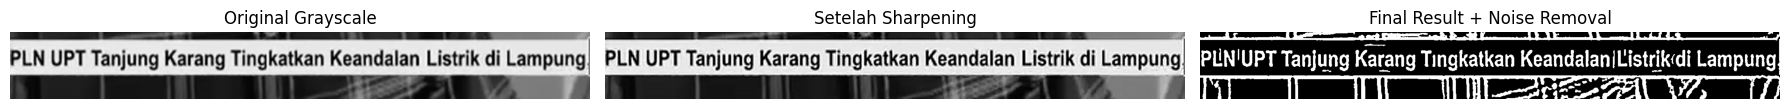

🔍 Hasil OCR - Metode Sharpening:
PEN UPT Tanjung Karang Tingkatkan Keandalan Listrik di Lampung


In [45]:
# ========================================
# TEKNIK 3: Sharpening untuk Meningkatkan Ketajaman Teks
# ========================================
# Memperjelas edge/tepi karakter

gray_sharp = cv2.cvtColor(resized_roi, cv2.COLOR_BGR2GRAY)

# Kernel sharpening
kernel_sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

sharpened = cv2.filter2D(gray_sharp, -1, kernel_sharpen)

# Thresholding setelah sharpening
blurred_sharp = cv2.GaussianBlur(sharpened, (5,5), 0)
thresh_sharp = cv2.adaptiveThreshold(
    blurred_sharp, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 
    19, 
    2
)

# Noise removal
opening_sharp = cv2.morphologyEx(thresh_sharp, cv2.MORPH_OPEN, kernel_small, iterations=1)

# Connected components filtering
num_labels_sharp, labels_sharp, stats_sharp, _ = cv2.connectedComponentsWithStats(opening_sharp, connectivity=8)
cleaned_sharp = np.zeros_like(opening_sharp)
for i in range(1, num_labels_sharp):
    if stats_sharp[i, cv2.CC_STAT_AREA] >= min_size:
        cleaned_sharp[labels_sharp == i] = 255

# Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].imshow(gray_sharp, cmap='gray')
axes[0].set_title('Original Grayscale')
axes[0].axis('off')

axes[1].imshow(sharpened, cmap='gray')
axes[1].set_title('Setelah Sharpening')
axes[1].axis('off')

axes[2].imshow(cleaned_sharp, cmap='gray')
axes[2].set_title('Final Result + Noise Removal')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# OCR comparison
ocr_ready_sharp = cv2.bitwise_not(cleaned_sharp)
text_sharp = pytesseract.image_to_string(ocr_ready_sharp, config=custom_config)
text_sharp_cleaned = ' '.join(text_sharp.strip().split())

print("🔍 Hasil OCR - Metode Sharpening:")
print("="*50)
print(text_sharp_cleaned)
print("="*50)

In [46]:
# ========================================
# PERBANDINGAN SEMUA METODE
# ========================================

print("\n" + "="*70)
print("📊 RINGKASAN PERBANDINGAN SEMUA METODE OCR")
print("="*70)

methods = [
    ("Adaptive Threshold (Standar)", text_cleaned),
    ("CLAHE Enhancement", text_clahe_cleaned if 'text_clahe_cleaned' in locals() else "N/A"),
    ("Otsu's Binarization", text_otsu_cleaned if 'text_otsu_cleaned' in locals() else "N/A"),
    ("Sharpening", text_sharp_cleaned if 'text_sharp_cleaned' in locals() else "N/A")
]

for i, (method_name, result) in enumerate(methods, 1):
    print(f"\n{i}. {method_name}:")
    print(f"   └─ {result}")
    print(f"   └─ Panjang: {len(result) if result != 'N/A' else 0} karakter")

print("\n" + "="*70)
print("💡 REKOMENDASI:")
print("="*70)
print("1. Pilih metode dengan hasil paling bersih dan akurat")
print("2. Untuk kontras rendah → Gunakan CLAHE")
print("3. Untuk background tidak uniform → Gunakan Adaptive Threshold")
print("4. Untuk teks blur → Gunakan Sharpening")
print("5. Untuk background uniform → Gunakan Otsu's")
print("="*70)


📊 RINGKASAN PERBANDINGAN SEMUA METODE OCR

1. Adaptive Threshold (Standar):
   └─ PEN UPT Tanjung Karang Tingkatkan Keandalan Listrik di Lampung
   └─ Panjang: 62 karakter

2. CLAHE Enhancement:
   └─ PAN UPT Tanjung Karang Tingkikan Keandalan Listik Lampung
   └─ Panjang: 57 karakter

3. Otsu's Binarization:
   └─ PLN UPT Tanjung Karang Tingkatkan Keandalan Lisinik di Lampung
   └─ Panjang: 62 karakter

4. Sharpening:
   └─ PEN UPT Tanjung Karang Tingkatkan Keandalan Listrik di Lampung
   └─ Panjang: 62 karakter

💡 REKOMENDASI:
1. Pilih metode dengan hasil paling bersih dan akurat
2. Untuk kontras rendah → Gunakan CLAHE
3. Untuk background tidak uniform → Gunakan Adaptive Threshold
4. Untuk teks blur → Gunakan Sharpening
5. Untuk background uniform → Gunakan Otsu's
